<a href="https://colab.research.google.com/github/torkralle/colab-overtone/blob/master/Vocoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 下準備


## ライブラリのインポート

In [1]:
%matplotlib inline
import sys
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import display, Audio
import scipy.io.wavfile
import copy

## 音声のインポート

In [2]:
# vocal_fs: rateボーカル音
vocal_path = "/content/drive/MyDrive/Laboratory/Colab/ホーミー対照音声1.wav"
Audio(vocal_path)
vocal_fs, vocal_s = wavfile.read(vocal_path)

# fs: rate, vocal_s: data ホーミー音 高音
ot_path = "/content/drive/MyDrive/Laboratory/Colab/高音.wav"
Audio(ot_path)
ot_fs, ot_s = wavfile.read(ot_path)

## 関数の定義

### ハイパスフィルターの定義

In [3]:
# 修正済み
def highpass_filter(s, length_of_s): 
  # 操作用の配列を用意
  d = np.zeros(length_of_s)
  d[0] = 0
  # ハイパスフィルターを掛ける
  for n in range(1, length_of_s):
    d[n] = s[n] - 0.98 * s[n-1]

  sc = copy.deepcopy(s)
  for n in range(length_of_s):
    sc[n] = d[n]
  
  return sc

### ハニング窓の定義

In [4]:
def hanning_window(N):
    w = np.zeros(N)
    if N % 2 == 0:
        for n in range(N):
            w[n] = 0.5 - 0.5 * np.cos(2 * np.pi * n / N)
    else:
        for n in range(N):
            w[n] = 0.5 - 0.5 * np.cos(2 * np.pi * (n + 0.5) / N)
    return w

def multiply_hanning_window():
    return   

### 音声データの作成関数の定義

In [5]:
def create_audio(fs, s, t, name):
  s = s * 1 / (np.max(np.abs(s)))
  out_path = f"out-{name}.wav"
  scipy.io.wavfile.write(out_path, fs, s)
  return out_path

### 平均系の関数群の定義

In [6]:
def get_average(offset, B):
    ave = 0
    # Bのバンド幅内の平均を取る作業	
    for k in range(band_width):
      ave = ave + B[offset + k]
    return ave / band_width

def fft_and_shape(b):
    B = np.fft.fft(b)

    for k in range(N):
        B[k] = abs(B[k])

    for band in range(number_of_band):
        # 開始位置の定義
        offset = band_width * (band - 1) 
        for k in range(band_width):
            B[offset + k] = get_average(offset, B)

    B[0] = 0
    B[int(np.round(N/2))] = 0

    # 左右に代入
    for k in range(1, int(np.round(N/2))):
        B[N - k] = B[k]
    
    return B

## データの前処理

### 必要な変数の定義

In [7]:
# サンプリング周波数
fs = 44100

# 2**16 65536
bits = 16
normalize_value = 2 ** (bits - 1)

# バッチ数
N = 1024

# 正規化
vocal_s = vocal_s.astype(np.float) / normalize_value
ot_s = ot_s.astype(np.float) / normalize_value

# vocalとovertoneの配列の長さを取得
length_of_vocal_s = len(vocal_s)
length_of_ot_s = len(ot_s)
print(f"ボーカルの配列長 {length_of_vocal_s}")
print(f"ホーミーの配列長 {length_of_ot_s}")

# ホーミーにハイパスフィルターを掛ける
ot_s_copy = highpass_filter(ot_s, length_of_ot_s)
new_audio = np.zeros(length_of_vocal_s)

ボーカルの配列長 141248
ホーミーの配列長 133056


In [8]:
# Nの数だけのゼロ配列
x = np.zeros(N)
b = np.zeros(N)

# Nサイズのハニング窓
w = hanning_window(N)
Y = np.zeros(N)

# N以外の場所を取って、フレーム数を調べる
# オーバーラップアドで半分重なってるためフレーム数は
number_of_frame = int(np.round((length_of_vocal_s - N/2) / (N/2)))

# 8個取ってきて平均を取る 
# バンド幅が8であるから2*8で割る(フーリエ変換の折り返し分の2)
band_width = 8
number_of_band = int(np.round(N / 2 / band_width))

### データの可視化


141248
133056


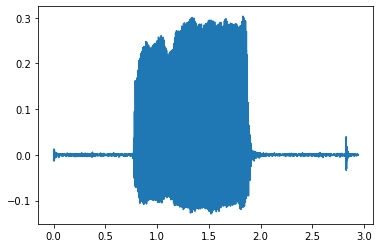

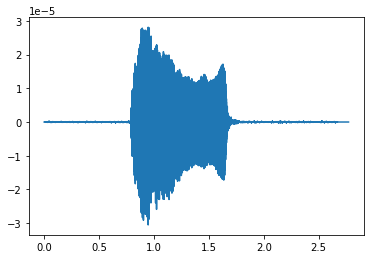

In [9]:
# 横軸（時間）の配列を作成　
# np.arange(初項, 等差数列の終点, 等差)
vocal_t = np.arange(0, vocal_s.shape[0]/vocal_fs, 1/vocal_fs)  
plt.figure()
plt.plot(vocal_t, vocal_s)
plt.savefig('vocal_s.png')
print(length_of_vocal_s)

ot_t = np.arange(0, ot_s.shape[0]/ot_fs, 1/ot_fs)  
plt.figure()
plt.plot(ot_t, ot_s)
plt.savefig('ot_s.png')
print(length_of_ot_s)

## 必要なデータの準備

# 本処理

In [10]:
# 全フレームに対して操作を行う
for frame in range(number_of_frame):
    #  操作開始場所を定義	
    offset = int(np.round(N / 2 * (frame - 1)))
    for n in range(N):
        x[n] = vocal_s[offset + n] * w[n]

		# Xが楽器音
    X = np.fft.fft(x)

    # print(frame)
    breakflag = False
    for n in range(N):
        ot_s_index = offset + n
        if(ot_s_index == length_of_ot_s):
          print("out", ot_s_index, frame)
          breakflag = True
          break
        b[n] = ot_s_copy[ot_s_index] * w[n]

    if(breakflag):
      break
    
    B = fft_and_shape(b)
 
		# ボーカル * ホーミーがY
    for k in range(N):
        Y[k] = X[k] * B[k]
    
    y = np.real(np.fft.ifft(Y))
    offset =  int(np.round(N / 2 * (frame - 1)))


		# new_audioに足す	
    for n in range(N):
        new_audio[offset+n] = new_audio[offset+n] + y[n]
    
new_audio = new_audio / max(new_audio) * 0.5

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: ComplexWarning: Casting complex values to real discards the imaginary part


out 133056 259


In [11]:
path = create_audio(fs, new_audio, vocal_t, "9")
Audio(path)